**This project explores how large language models (LLMs) create text, with a focus on often ignored yet vital <br>
decoding strategies such as beam search. We'll delve into how greedy search, beam search, and methods like top-k <br>
and nucleus sampling work. By the end of the notebook, you'll have a clear understanding of these decoding <br>
strategies and know how to use key settings such as temperature, num_beams, top_k, and top_p.**

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

**We’ll feed the text “I have a dream” to a GPT-2 model and ask it to generate the next five tokens (words or subwords).**

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model.eval()

text = "I have a dream"
input_ids = tokenizer.encode(text, return_tensors='pt').to(device)

outputs = model.generate(input_ids, max_length=len(input_ids.squeeze())+5)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"Generated text: {generated_text}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated text: I have a dream of being a doctor.


**The statement "I have a dream of being a doctor" seems to have been made by GPT-2. However, GPT-2 didn't really create this sentence. 
Many people mistakenly believe that large language models like GPT-2 create text directly. This isn't true. Rather, these models compute 
'logits', scores given to each potential word in their vocabulary. To make this easier to understand, let's break down the process:**

**In this process, a tokenizer (Byte-Pair Encoding in this case) converts each word in the text into a unique ID. GPT-2 takes these IDs and tries to guess the next most likely word. The model then creates logits, which are changed into probabilities with a function called softmax.
For instance, the model might decide there's a 17% chance that the next word after "I have a dream" will be "of". This outcome is like a ranked list of the possible next words. In more formal terms, we say this probability as P(of | I have a dream) = 17%.
Models like GPT predict the next word in a sentence based on the words before it.**

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

# **Greedy Search**

Greedy search is a decoding method that takes the most probable token at each step as the next token in the sequence. To put it simply, it only retains the most likely token at each stage, discarding all other potential options. Using our example:

Step 1: Input: “I have a dream” → Most likely token: “ of” <br>
Step 2: Input: “I have a dream of” → Most likely token: “ being” <br>
Step 3: Input: “I have a dream of being” → Most likely token: “ a”<br>
Step 4: Input: “I have a dream of being a” → Most likely token: “ doctor”<br>
Step 5: Input: “I have a dream of being a doctor” → Most likely token: “.”

While this approach might sound intuitive, it’s important to note that the greedy search is short-sighted: it only considers <br>
the most probable token at each step without considering the overall effect on the sequence.

In [5]:
def get_log_prob(logits, token_id):
    # Compute the softmax of the logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    log_probabilities = torch.log(probabilities)
    
    # Get the log probability of the token
    token_log_probability = log_probabilities[token_id].item()
    return token_log_probability

def greedy_search(input_ids, node, length=5):
    if length == 0:
        return input_ids

    outputs = model(input_ids)
    predictions = outputs.logits

    # Get the predicted next sub-word (here we use top-k search)
    logits = predictions[0, -1, :]
    token_id = torch.argmax(logits).unsqueeze(0)

    # Compute the score of the predicted token
    token_score = get_log_prob(logits, token_id)

    # Add the predicted token to the list of input ids
    new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0)], dim=-1)

    # Add node and edge to graph
    next_token = tokenizer.decode(token_id, skip_special_tokens=True)
    current_node = list(graph.successors(node))[0]
    graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
    graph.nodes[current_node]['token'] = next_token + f"_{length}"

    # Recursive call
    input_ids = greedy_search(new_input_ids, current_node, length-1)
    
    return input_ids


In [6]:
# Parameters
length = 5
beams = 1

# Create a balanced tree with height 'length'
graph = nx.balanced_tree(1, length, create_using=nx.DiGraph())

# Add 'tokenscore', 'cumscore', and 'token' attributes to each node
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['token'] = text

# Start generating text
output_ids = greedy_search(input_ids, 0, length=length)
output = tokenizer.decode(output_ids.squeeze().tolist(), skip_special_tokens=True)
print(f"Generated text: {output}")

Generated text: I have a dream of being a doctor.


In [7]:
!pip install pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.8/120.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pygraphviz: filename=pygraphviz-1.11-cp310-cp310-linux_x86_64.whl size=104682 sha256=09c5fd6fdb6fd77151a439d2292e702eafb35d96d82567650d65e2747215b0b6
  Stored in directory: /root/.cache/pip/wheels/5b/ee/36/f47a0d35664fbe1a2b5a433ae33c6ad636b00bb231f68a9aaa
Successfully built pygraphviz


In [8]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def plot_graph(graph, length, beams, score):
    fig, ax = plt.subplots(figsize=(3+1.2*beams**length, max(5, 2+length)), dpi=300, facecolor='white')

    # Create positions for each node
    pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")

    # Normalize the colors along the range of token scores
    if score == 'token':
        scores = [data['tokenscore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    elif score == 'sequence':
        scores = [data['sequencescore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    vmin = min(scores)
    vmax = max(scores)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = LinearSegmentedColormap.from_list('rg', ["r", "y", "g"], N=256) 

    # Draw the nodes
    nx.draw_networkx_nodes(graph, pos, node_size=2000, node_shape='o', alpha=1, linewidths=4, 
                          node_color=scores, cmap=cmap)

    # Draw the edges
    nx.draw_networkx_edges(graph, pos)

    # Draw the labels
    if score == 'token':
        labels = {node: data['token'].split('_')[0] + f"\n{data['tokenscore']:.2f}%" for node, data in graph.nodes(data=True) if data['token'] is not None}
    elif score == 'sequence':
        labels = {node: data['token'].split('_')[0] + f"\n{data['sequencescore']:.2f}" for node, data in graph.nodes(data=True) if data['token'] is not None}
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
    plt.box(False)

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    if score == 'token':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Token probability (%)')
    elif score == 'sequence':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Sequence score')
    plt.show()


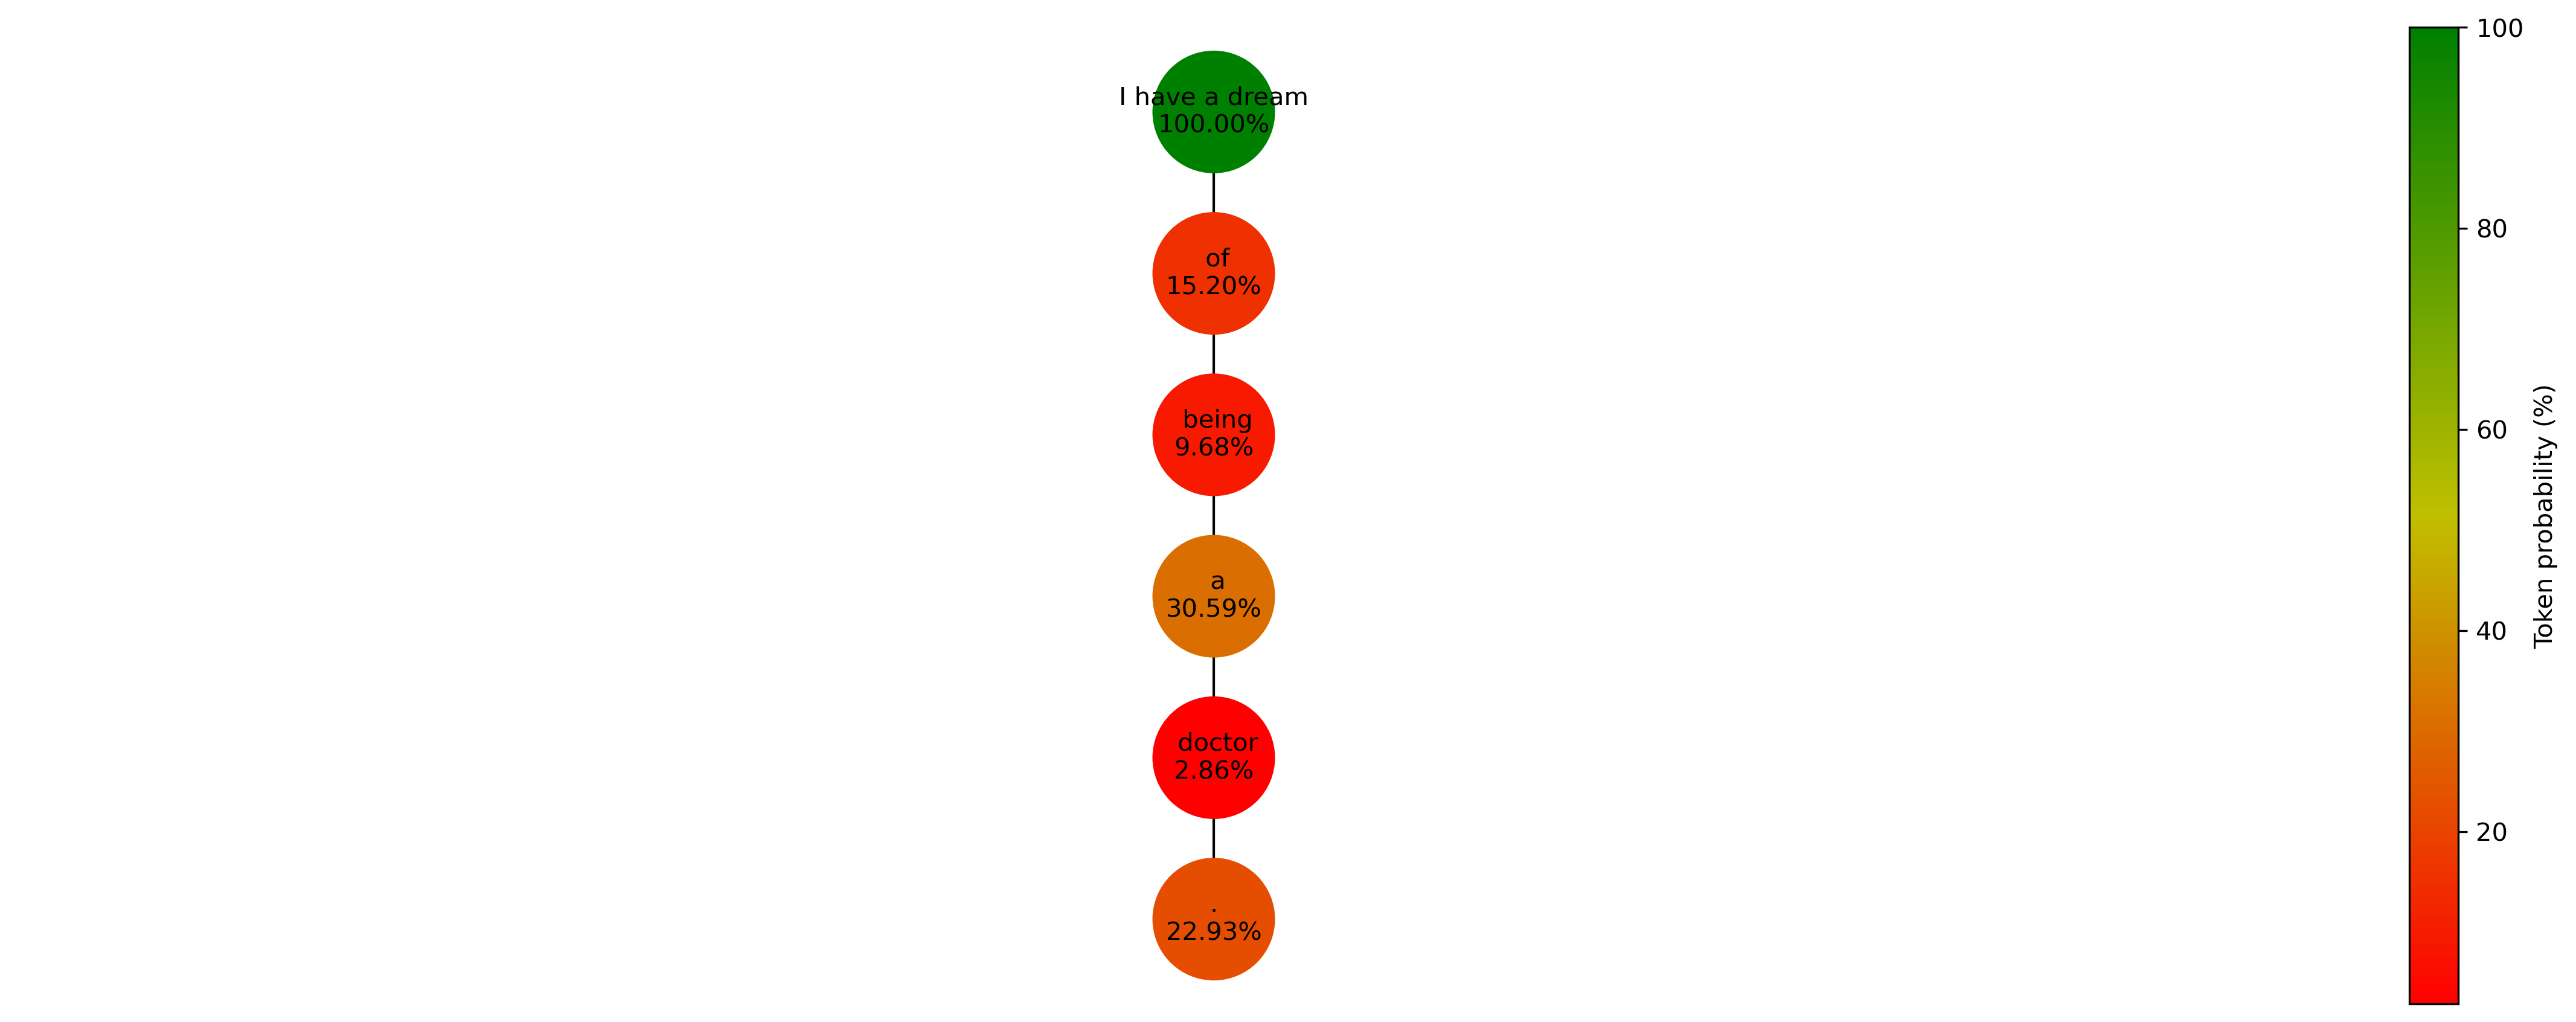

In [9]:
# Plot graph
plot_graph(graph, length, 1.7, 'token')

**In the graph, the first node contains the initial word (so it has a 100% chance), and all other nodes represent <br>
the words generated. While each word was the most probable when predicted, the words "being" and "doctor" only had <br>
low chances of 9.68% and 2.86% respectively. This implies that "of", the first word predicted, might not have been <br>
the best choice since it led to "being", which was quite unexpected.**

# **Beam Search**

**Beam search, unlike greedy search that only looks at the next most likely word, considers the top 'n' likely words, where 'n' <br>
is the number of beams. This process is repeated until a set maximum length is reached or an end-of-sentence word is found. <br>
At this point, the sequence (or "beam") with the highest total score is selected as the output.We can modify the previous function <br>
to look at the top 'n' most likely words instead of just one. We'll keep track of the sequence score log P(w), which is the total <br>
of the log probabilities of each word in the beam. We adjust this score by the sequence length to avoid favoring longer sequences <br>
(this factor can be changed). We'll create five more words to finish the sentence "I have a dream."**








In [10]:
from tqdm.notebook import tqdm

def greedy_sampling(logits, beams):
    return torch.topk(logits, beams).indices
    
def beam_search(input_ids, node, bar, length, beams, sampling, temperature=0.1):
    if length == 0:
        return None

    outputs = model(input_ids)
    predictions = outputs.logits

    # Get the predicted next sub-word (here we use top-k search)
    logits = predictions[0, -1, :]

    if sampling == 'greedy':
        top_token_ids = greedy_sampling(logits, beams)
    elif sampling == 'top_k':
        top_token_ids = top_k_sampling(logits, temperature, 20, beams)
    elif sampling == 'nucleus':
        
        top_token_ids = nucleus_sampling(logits, temperature, 0.4, beams)

    for j, token_id in enumerate(top_token_ids):
        bar.update(1)

        # Compute the score of the predicted token
        token_score = get_log_prob(logits, token_id)
        cumulative_score = graph.nodes[node]['cumscore'] + token_score

        # Add the predicted token to the list of input ids
        new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0).unsqueeze(0)], dim=-1)

        # Add node and edge to graph
        token = tokenizer.decode(token_id, skip_special_tokens=True)
        current_node = list(graph.successors(node))[j]
        graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
        graph.nodes[current_node]['cumscore'] = cumulative_score
        graph.nodes[current_node]['sequencescore'] = 1/(len(new_input_ids.squeeze())) * cumulative_score
        graph.nodes[current_node]['token'] = token + f"_{length}_{j}"

        # Recursive call
        beam_search(new_input_ids, current_node, bar, length-1, beams, sampling, 1)


In [11]:
# Parameters
length = 5
beams = 2

# Create a balanced tree with height 'length' and branching factor 'k'
graph = nx.balanced_tree(beams, length, create_using=nx.DiGraph())
bar = tqdm(total=len(graph.nodes))

# Add 'tokenscore', 'cumscore', and 'token' attributes to each node
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['cumscore'] = 0
    graph.nodes[node]['sequencescore'] = 0
    graph.nodes[node]['token'] = text

# Start generating text
beam_search(input_ids, 0, bar, length, beams, 'greedy', 1)

  0%|          | 0/63 [00:00<?, ?it/s]

In [12]:
def get_best_sequence(G):
    # Create a list of leaf nodes
    leaf_nodes = [node for node in G.nodes() if G.out_degree(node)==0]

    # Get the leaf node with the highest cumscore
    max_score_node = None
    max_score = float('-inf')
    for node in leaf_nodes:
        if G.nodes[node]['sequencescore'] > max_score:
            max_score = G.nodes[node]['sequencescore']
            max_score_node = node

    # Retrieve the sequence of nodes from this leaf node to the root node in a list
    path = nx.shortest_path(G, source=0, target=max_score_node)

    # Return the string of token attributes of this sequence
    sequence = "".join([G.nodes[node]['token'].split('_')[0] for node in path])
    
    return sequence, max_score

sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: I have a dream. I have a dream


**The best sequence seems to be “I have a dream. I have a dream,” which is a common response from GPT-2, even though <br>
it may be surprising. To verify this, let’s plot the graph.**

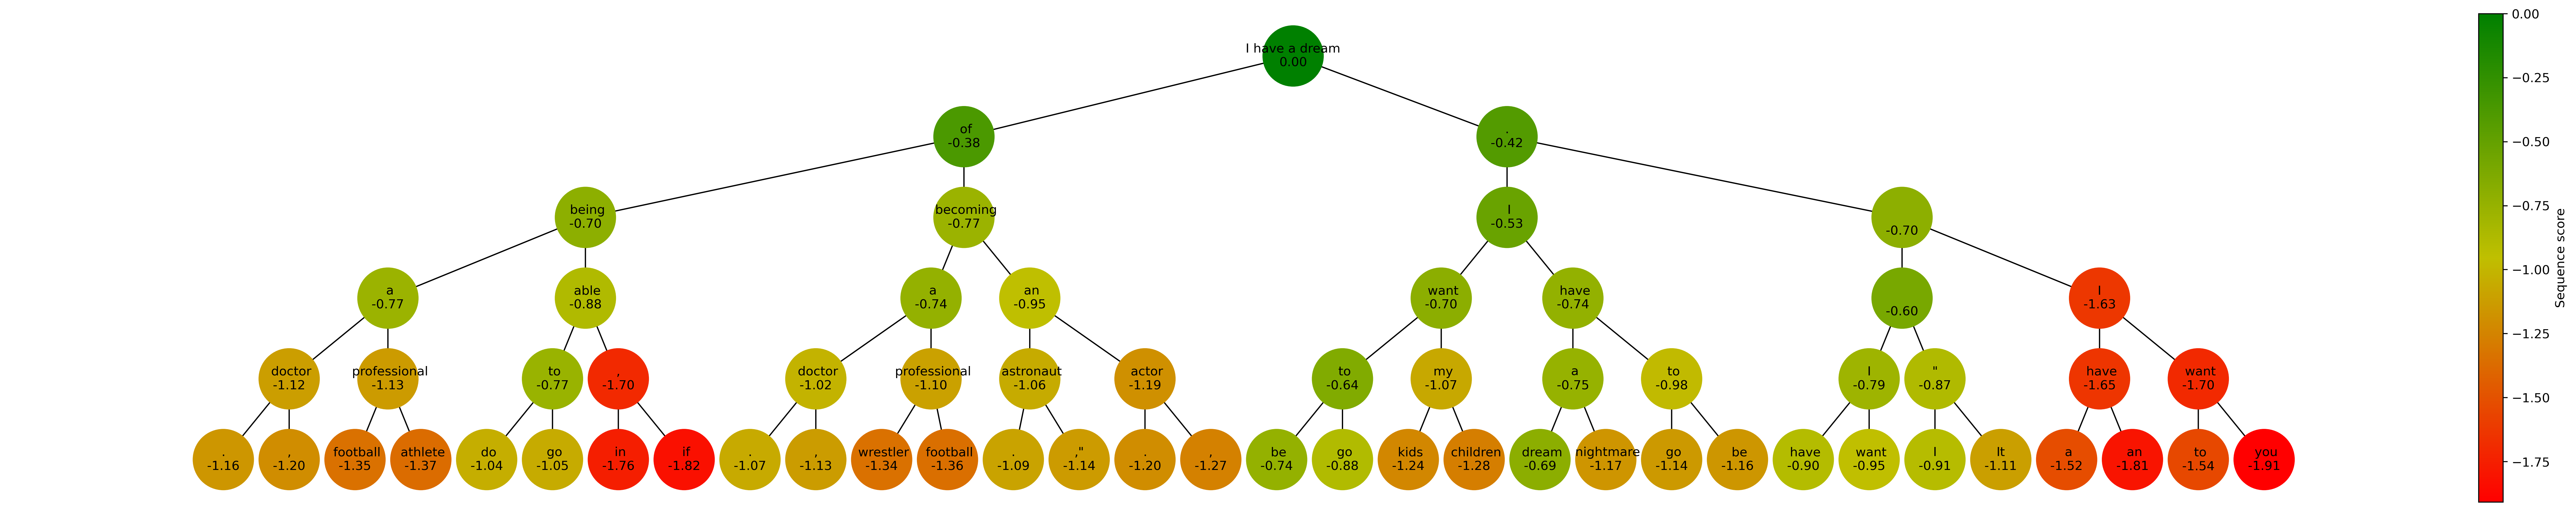

In [13]:
# Plot graph
plot_graph(graph, length, beams, 'sequence')


**The word "dream" has the top sequence score, with a value of -0.69. Interestingly, the score of the sequence <br>
"I have a dream of being a doctor," produced by the greedy search, is lower at -1.16.As anticipated, the greedy <br>
search gives less than perfect results. However, our new result isn't very impressive either. To create more <br>
diverse sentences, we'll use two sampling methods: top-k and nucleus.**

# **Top-k sampling**

**Top-k sampling is a method where the language model randomly picks a word from the top k most likely options, based on the probability distribution. <br>
For example, if we have four words: A, B, C, D, with probabilities: P(A) = 30%, P(B) = 15%, P(C) = 5%, P(D) = 1%, and k = 3, D is ignored. <br>
The model will then output A 60% of the time, B 30%, and C 10%, balancing high likelihood with randomness. Another way to add randomness is 'temperature'. <br>
It's a value between 0 and 1 that influences probabilities, making the most probable words more dominant. Practically, it involves dividing <br>
the input logits by this 'temperature'**

In [14]:
def plot_prob_distribution(probabilities, next_tokens, sampling, potential_nb, total_nb=50):
    # Get top k tokens
    top_k_prob, top_k_indices = torch.topk(probabilities, total_nb)
    top_k_tokens = [tokenizer.decode([idx]) for idx in top_k_indices.tolist()]

    # Get next tokens and their probabilities
    next_tokens_list = [tokenizer.decode([idx]) for idx in next_tokens.tolist()]
    next_token_prob = probabilities[next_tokens].tolist()

    # Create figure
    plt.figure(figsize=(0.4*total_nb, 5), dpi=300, facecolor='white')
    plt.rc('axes', axisbelow=True)
    plt.grid(axis='y', linestyle='-', alpha=0.5)
    if potential_nb < total_nb:
        plt.axvline(x=potential_nb-0.5, ls=':', color='grey', label='Sampled tokens')
    plt.bar(top_k_tokens, top_k_prob.tolist(), color='blue')
    plt.bar(next_tokens_list, next_token_prob, color='red', label='Selected tokens')
    plt.xticks(rotation=45, ha='right', va='top')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if sampling == 'top_k':
        plt.title('Probability distribution of predicted tokens with top-k sampling')
    elif sampling == 'nucleus':
        plt.title('Probability distribution of predicted tokens with nucleus sampling')
    plt.legend()
    plt.savefig(f'{sampling}_{time.time()}.png', dpi=300)
    plt.close()

def top_k_sampling(logits, temperature, top_k, beams, plot=True):
    assert top_k >= 1
    assert beams <= top_k

    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    new_logits = torch.clone(logits)
    new_logits[indices_to_remove] = float('-inf')

    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(new_logits / temperature, dim=-1)

    # Sample n tokens from the resulting distribution
    next_tokens = torch.multinomial(probabilities, beams)

    # Plot distribution
    if plot:
        total_prob = torch.nn.functional.softmax(logits / temperature, dim=-1)
        plot_prob_distribution(total_prob, next_tokens, 'top_k', top_k)

    return next_tokens


In [15]:
# Start generating text
beam_search(input_ids, 0, bar, length, beams, 'top_k', 1)

In [16]:
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: I have a dream to be an astronaut.


**The top-k sampling found a new sequence: which feels significantly more natural than “I have a dream. I have a dream”.**

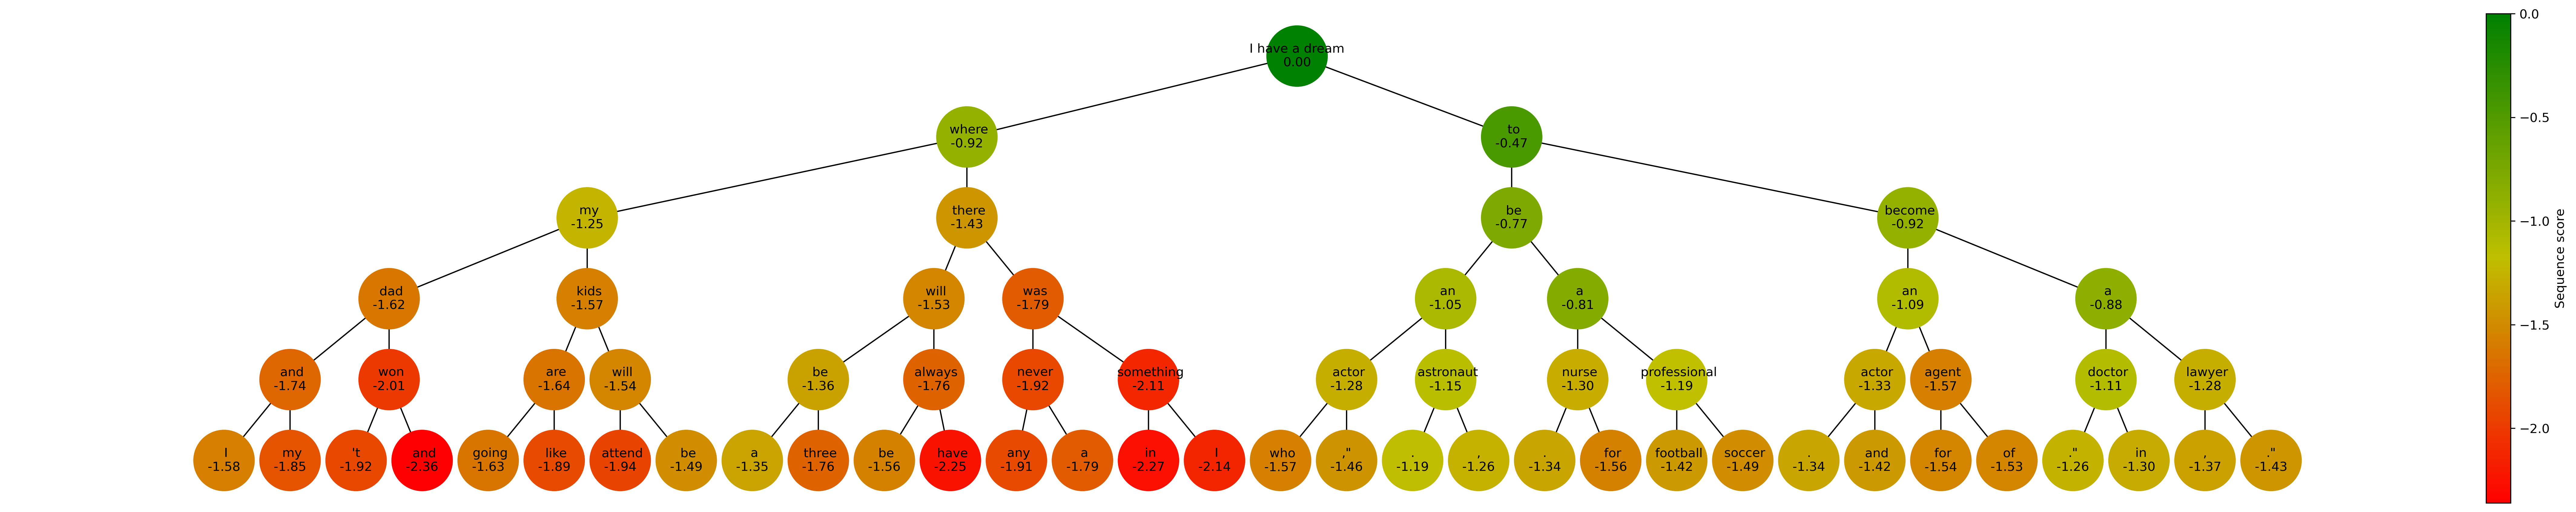

In [17]:
# Plot graph
plot_graph(graph, length, beams, 'sequence')

**You can see how the nodes differ significantly from the previous iteration, making more diverse choices. <br>
Although the sequence score of this new outcome might not be the highest (-1.01 instead of -0.69 previously), <br>
it’s important to remember that higher scores do not always lead to more realistic or meaningful sequences.**

# **Nucleus Sampling**

**Nucleus sampling, or top-p sampling, is a method used in text generation that selects a group of top probable tokens <br>
until their combined probability exceeds a preset value (p). Unlike top-k sampling, which fixes the number of tokens, <br>
nucleus sampling allows this number to vary, enhancing output diversity and creativity. In practice, it can be implemented <br>
using the "nucleus" parameter in the beam_search() function, setting the value of p and considering tokens with cumulative <br>
probabilities less than p. Regardless of the details, the central concept of nucleus sampling stays consistent.**

In [18]:
def nucleus_sampling(logits, temperature, p, beams, plot=True):
    assert p > 0
    assert p <= 1

    # Sort the probabilities in descending order and compute cumulative probabilities
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    cumulative_probabilities = torch.cumsum(probabilities, dim=-1)

    # Create a mask for probabilities that are in the top-p
    mask = cumulative_probabilities < p

    # If there's not n index where cumulative_probabilities < p, we use the top n tokens instead
    if mask.sum() > beams:
        top_p_index_to_keep = torch.where(mask)[0][-1].detach().cpu().tolist()
    else:
        top_p_index_to_keep = beams

    # Only keep top-p indices
    indices_to_remove = sorted_indices[top_p_index_to_keep:]
    sorted_logits[indices_to_remove] = float('-inf')

    # Sample n tokens from the resulting distribution
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    next_tokens = torch.multinomial(probabilities, beams)

    # Plot distribution
    if plot:
        total_prob = torch.nn.functional.softmax(logits / temperature, dim=-1)
        plot_prob_distribution(total_prob, next_tokens, 'nucleus', top_p_index_to_keep)

    return next_tokens

In [19]:
# Start generating text
beam_search(input_ids, 0, bar, length, beams, 'nucleus', 1)

In [20]:
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: I have a dream. I have a dream


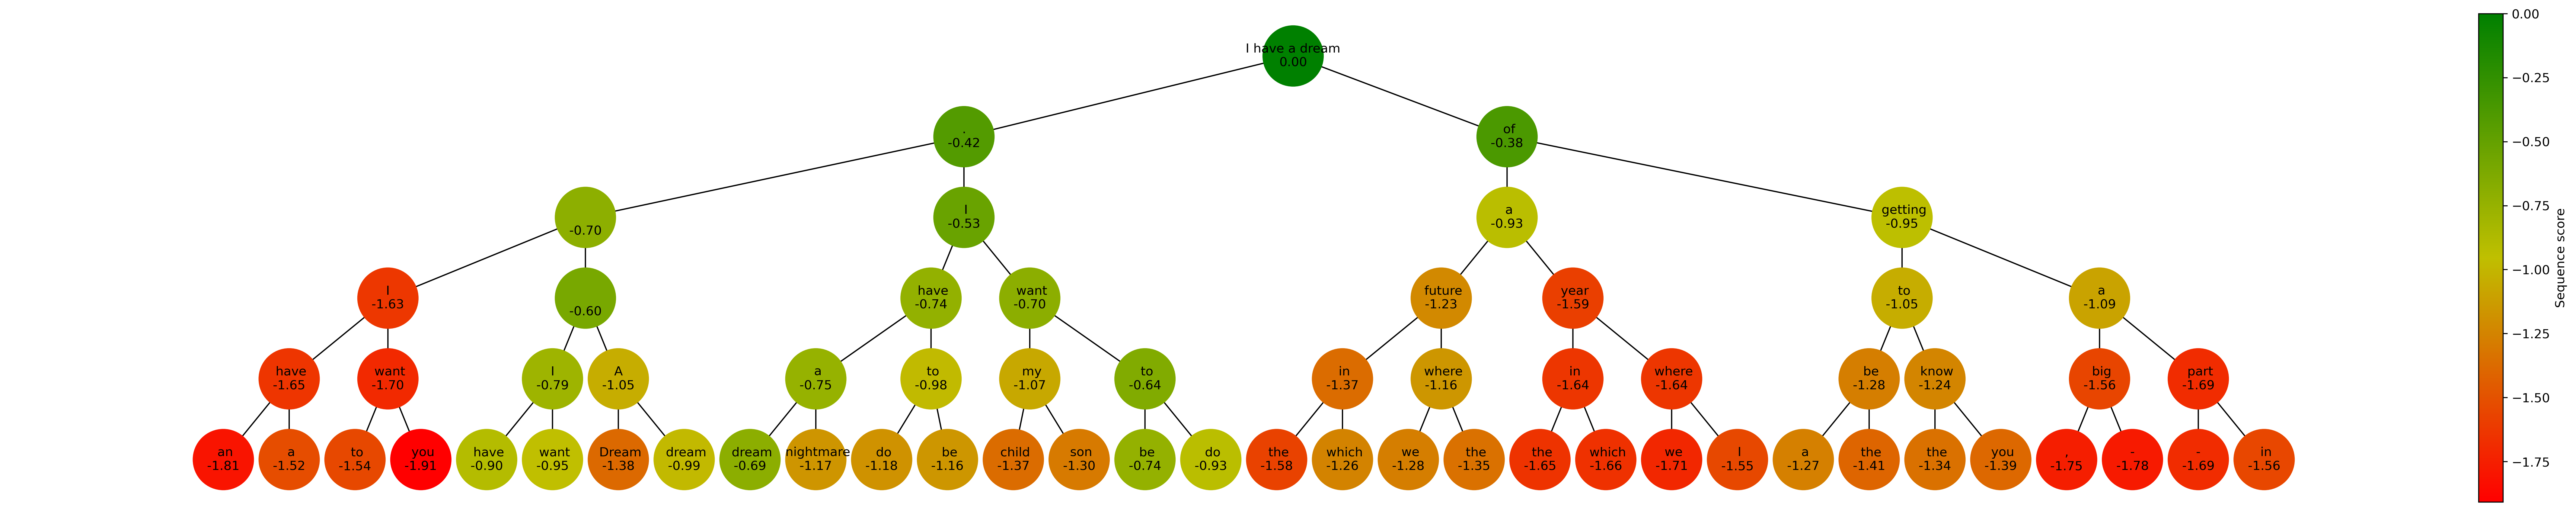

In [21]:
# Plot graph
plot_graph(graph, length, beams, 'sequence')

# **Conclusion**

**Decoding methods like greedy search, beam search, top-k and nucleus sampling are used by Language Learning Models (LLMs) like GPT-2 <br>
for text generation. Greedy search picks the most probable next token, often yielding suboptimal results. Beam search considers several <br>
likely tokens, offering nuanced results but lacking diversity. Top-k sampling adds diversity by randomly choosing from the k most probable tokens. <br>
Nucleus sampling dynamically creates a token nucleus based on cumulative probability, promoting diversity and creativity. Each method has strengths <br>
and drawbacks, influencing its suitability based on project requirements. Understanding these techniques aids in better directing LLMs to generate <br>
more realistic, nuanced, and compelling text.**